<a href="https://colab.research.google.com/github/Manvi1718/Emotion_Analysis/blob/main/MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion analysis

## Connecting dataset with kaggle


In [1]:
import os
os.environ["KAGGLE_USERNAME"] = "annmittal"
os.environ["KAGGLE_KEY"] ="b36a820c483a21bd0633e9b284bbc42c"

!kaggle datasets download -d shawon10/ckplus

  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 211MB/s]


In [2]:
!unzip ckplus.zip

Archive:  ckplus.zip
  inflating: CK+48/anger/S010_004_00000017.png  
  inflating: CK+48/anger/S010_004_00000018.png  
  inflating: CK+48/anger/S010_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000020.png  
  inflating: CK+48/anger/S011_004_00000021.png  
  inflating: CK+48/anger/S014_003_00000028.png  
  inflating: CK+48/anger/S014_003_00000029.png  
  inflating: CK+48/anger/S014_003_00000030.png  
  inflating: CK+48/anger/S022_005_00000030.png  
  inflating: CK+48/anger/S022_005_00000031.png  
  inflating: CK+48/anger/S022_005_00000032.png  
  inflating: CK+48/anger/S026_003_00000013.png  
  inflating: CK+48/anger/S026_003_00000014.png  
  inflating: CK+48/anger/S026_003_00000015.png  
  inflating: CK+48/anger/S028_001_00000022.png  
  inflating: CK+48/anger/S028_001_00000023.png  
  inflating: CK+48/anger/S028_001_00000024.png  
  inflating: CK+48/anger/S029_001_00000017.png  
  inflating: CK+48/anger/S029_001_00000018.png  

## Loading libraries

In [3]:
pip install split-folders

In [4]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=14af8a4f39c0175cc04698e692152326c173adc034e9f165651c47ffdf3f9ebb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [49]:
import torch
from torch import nn
import torchvision
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#import albumentations
#from albumentations import pytorch as AT
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import csv
from PIL import Image
import splitfolders
import os
from torchvision.datasets import ImageFolder
import zipfile
from efficientnet_pytorch import EfficientNet

## Setup device agnostic code

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
'''#Splitting dataset into train ,test and validation

original="/content/drive/MyDrive/pytorch/ck+/CK+48"
splitted="/content/drive/MyDrive/pytorch/ck+/CK+48 splitted"

splitfolders.ratio(original,output=splitted,seed=1337,ratio=(.75,.25),group_prefix=None)
'''

'#Splitting dataset into train ,test and validation\n\noriginal="/content/drive/MyDrive/pytorch/ck+/CK+48"\nsplitted="/content/drive/MyDrive/pytorch/ck+/CK+48 splitted"\n\nsplitfolders.ratio(original,output=splitted,seed=1337,ratio=(.75,.25),group_prefix=None)\n'

In [8]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
%cd '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted'

/content/drive/MyDrive/pytorch/ck+/CK+48 splitted


In [10]:
# To unzip files
"""
#Extract Zip File
with zipfile.ZipFile('train.zip', 'r') as zip_ref:
    zip_ref.extractall('train')

with zipfile.ZipFile('test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')
"""

"\n#Extract Zip File\nwith zipfile.ZipFile('train.zip', 'r') as zip_ref:\n    zip_ref.extractall('train')\n\nwith zipfile.ZipFile('test.zip', 'r') as zip_ref:\n    zip_ref.extractall('test')\n"

In [51]:
# Define transformations, including converting to grayscale
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale with 1 channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),  # Adjust mean and std for 1-channel grayscale
])

In [52]:
# Path to the root directory of your train and test data in Google Drive
train_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/train_d'
test_data_path = '/content/drive/MyDrive/pytorch/ck+/CK+48 splitted/test_d'

# List of emotion labels
emotion_labels = [
    'anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'
]

In [53]:
class CustomDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, filename) for filename in os.listdir(root) if filename.endswith(".png")]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        # Manually extract the emotion label from the filename
        emotion_label = image_path.split('/')[-1].split('_')[0]

        # Handle variations in emotion labels
        if emotion_label == 'happy':
            emotion_label = 'happiness'

        # Get the label index from the emotion_labels list
        label = emotion_labels.index(emotion_label)

        return image, label

In [54]:
# Load custom train and test datasets
train_dataset = CustomDataset(train_data_path, transform=transform)
test_dataset = CustomDataset(test_data_path, transform=transform)

In [55]:
# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [56]:
"""# Access labels in the train DataLoader
for images, labels in train_dataloader:
    for label in labels:
        emotion_label = emotion_labels[label]
        print(f"Train Emotion Label: {emotion_label}")

# Access labels in the test DataLoader
for images, labels in test_dataloader:
    for label in labels:
        emotion_label = emotion_labels[label]
        print(f"Test Emotion Label: {emotion_label}")
"""

'# Access labels in the train DataLoader\nfor images, labels in train_dataloader:\n    for label in labels:\n        emotion_label = emotion_labels[label]\n        print(f"Train Emotion Label: {emotion_label}")\n\n# Access labels in the test DataLoader\nfor images, labels in test_dataloader:\n    for label in labels:\n        emotion_label = emotion_labels[label]\n        print(f"Test Emotion Label: {emotion_label}")\n'

In [57]:
len(train_dataloader) , len(test_dataloader)

(23, 8)

In [58]:
len(train_dataset) , len(test_dataset)

(725, 248)

In [59]:
# see the first training example
image , label = train_dataset[0]
image , label

(tensor([[[1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          [1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          [1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          ...,
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536],
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536],
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536]],
 
         [[1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          [1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          [1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          ...,
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536],
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536],
          [0.8961, 0.8961, 0.8961,  ..., 0.5536, 0.5536, 0.5536]],
 
         [[1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          [1.6495, 1.6495, 1.6495,  ..., 0.9474, 0.9646, 0.9646],
          [1.6495, 1.6495, 1.6495,  ...,

In [60]:
class_names=emotion_labels
class_names

['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [61]:
# Chcek the shape
print(f"image shape : {image.shape}")
print(f"image label : {class_names[label]}")

image shape : torch.Size([3, 224, 224])
image label : contempt


In [62]:
print(emotion_labels[3])

fear


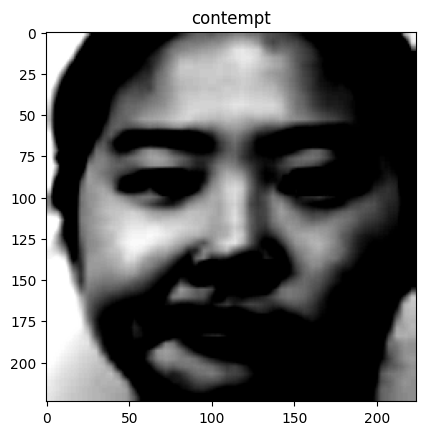

In [63]:
# Assuming your image is in the shape (3, 224, 224)
image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title(emotion_labels[label])
plt.show()


In [64]:
from torchvision.transforms import Grayscale

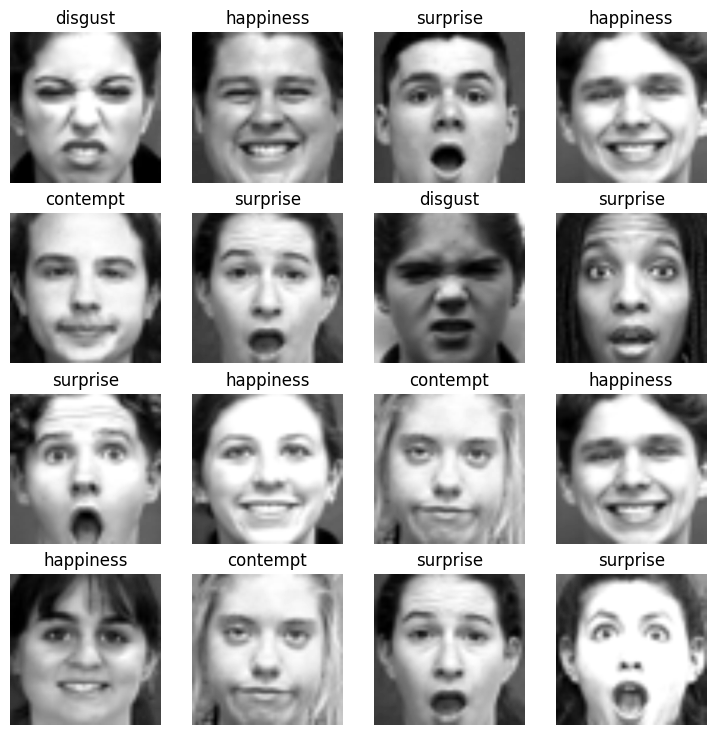

In [65]:
# plot more images
torch.manual_seed(42)
fig =plt.figure(figsize = (9,9))
rows , cols = 4,4

transform = Grayscale(num_output_channels=1)

for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_dataset) , size =[1]).item()
  img , label = train_dataset[random_idx]

  img= transform(img)

  fig.add_subplot(rows,cols , i)
  plt.imshow(img.squeeze() ,cmap="gray")
  plt.title(emotion_labels[label])
  plt.axis(False)

In [66]:
train_dataset , test_dataset

(<__main__.CustomDataset at 0x78f49819b9a0>,
 <__main__.CustomDataset at 0x78f49819baf0>)

In [67]:

# Lets check out what we have created
print(f"dataloaders : {train_dataloader , test_dataloader}")
print(f" length of train_dataloader : {len(train_dataloader)} batches of {batch_size}....")
print(f" length of test_dataloader : {len(test_dataloader)} batches of {batch_size}...")

dataloaders : (<torch.utils.data.dataloader.DataLoader object at 0x78f49819ba90>, <torch.utils.data.dataloader.DataLoader object at 0x78f498198370>)
 length of train_dataloader : 23 batches of 32....
 length of test_dataloader : 8 batches of 32...


In [68]:
# Check out whats inside the training dataloader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

#Importing models

In [73]:
import torchvision.models as models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

#MODEL-1 -- EfficientNet

In [70]:
#1 EfficientNet -- Loading Model
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0')
print(efficientnet_model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

In [71]:
# Modify the model's final layers
num_classes = len(class_names)
efficientnet_model._fc = nn.Linear(efficientnet_model._fc.in_features, num_classes)  # Modify the last fully connected layer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientnet_model.parameters(), lr=0.001)

# Training loop
efficientnet_model.to(device)

num_epochs = 10
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    efficientnet_model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for image, label in train_dataloader:
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += label.size(0)
        total_correct += (predicted == label).sum().item()
        total_loss += loss.item()

    # Calculate training accuracy and loss for this epoch
    epoch_train_accuracy = 100 * total_correct / total_samples
    epoch_train_loss = total_loss / len(train_dataloader)

    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%')

    # Evaluate the model on the test dataset
    efficientnet_model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for image, label in test_dataloader:
            image, label = image.to(device), label.to(device)

            outputs = efficientnet_model(image)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += label.size(0)
            total_correct += (predicted == label).sum().item()
            total_loss += loss.item()

    # Calculate testing accuracy and loss for this epoch
    epoch_test_accuracy = 100 * total_correct / total_samples
    epoch_test_loss = total_loss / len(test_dataloader)

    test_loss_history.append(epoch_test_loss)
    test_accuracy_history.append(epoch_test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%')

# Print final training and testing accuracy and loss
final_train_accuracy = train_accuracy_history[-1]
final_train_loss = train_loss_history[-1]
final_test_accuracy = test_accuracy_history[-1]
final_test_loss = test_loss_history[-1]

print(f'Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_accuracy:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%')

# Save the trained model if needed
##torch.save(efficientnet_model.state_dict(), 'custom_model1.pth')


Epoch [1/10], Train Loss: 0.8198, Train Accuracy: 72.83%
Epoch [1/10], Test Loss: 3.4902, Test Accuracy: 47.98%
Epoch [2/10], Train Loss: 0.2120, Train Accuracy: 93.24%
Epoch [2/10], Test Loss: 2.5624, Test Accuracy: 52.02%
Epoch [3/10], Train Loss: 0.0926, Train Accuracy: 97.10%
Epoch [3/10], Test Loss: 0.7097, Test Accuracy: 77.82%
Epoch [4/10], Train Loss: 0.0881, Train Accuracy: 96.97%
Epoch [4/10], Test Loss: 0.6720, Test Accuracy: 80.65%
Epoch [5/10], Train Loss: 0.0293, Train Accuracy: 99.03%
Epoch [5/10], Test Loss: 0.4797, Test Accuracy: 84.68%
Epoch [6/10], Train Loss: 0.0615, Train Accuracy: 98.48%
Epoch [6/10], Test Loss: 0.2314, Test Accuracy: 94.76%
Epoch [7/10], Train Loss: 0.0718, Train Accuracy: 98.48%
Epoch [7/10], Test Loss: 0.6574, Test Accuracy: 80.24%
Epoch [8/10], Train Loss: 0.0791, Train Accuracy: 97.66%
Epoch [8/10], Test Loss: 1.4618, Test Accuracy: 72.58%
Epoch [9/10], Train Loss: 0.0784, Train Accuracy: 98.21%
Epoch [9/10], Test Loss: 0.9050, Test Accuracy:

#MODEL-2 -- VGG16


In [30]:
# VGG16 -- Loading Model
vgg16_model = models.vgg16(pretrained=True)
print(vgg16_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 272MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [72]:
# Modify the model's final layers
num_classes = len(class_names)
vgg16_model.classifier[6] = nn.Linear(4096, num_classes)  # Modify the last fully connected layer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16_model.parameters(), lr=0.001)

# Training loop
vgg16_model.to(device)

num_epochs = 10
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    vgg16_model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for image, label in train_dataloader:
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = vgg16_model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += label.size(0)
        total_correct += (predicted == label).sum().item()
        total_loss += loss.item()

    # Calculate training accuracy and loss for this epoch
    epoch_train_accuracy = 100 * total_correct / total_samples
    epoch_train_loss = total_loss / len(train_dataloader)

    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%')

    # Evaluate the model on the test dataset
    vgg16_model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for image, label in test_dataloader:
            image, label = image.to(device), label.to(device)

            outputs = vgg16_model(image)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += label.size(0)
            total_correct += (predicted == label).sum().item()
            total_loss += loss.item()

    # Calculate testing accuracy and loss for this epoch
    epoch_test_accuracy = 100 * total_correct / total_samples
    epoch_test_loss = total_loss / len(test_dataloader)

    test_loss_history.append(epoch_test_loss)
    test_accuracy_history.append(epoch_test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%')

# Print final training and testing accuracy and loss
final_train_accuracy = train_accuracy_history[-1]
final_train_loss = train_loss_history[-1]
final_test_accuracy = test_accuracy_history[-1]
final_test_loss = test_loss_history[-1]

print(f'Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_accuracy:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}%')

# Save the trained model if needed
##torch.save(vgg16_model.state_dict(), 'custom_model2.pth')

Epoch [1/10], Train Loss: 2.0243, Train Accuracy: 22.76%
Epoch [1/10], Test Loss: 1.8187, Test Accuracy: 25.40%
Epoch [2/10], Train Loss: 1.9079, Train Accuracy: 23.45%
Epoch [2/10], Test Loss: 1.8526, Test Accuracy: 18.15%
Epoch [3/10], Train Loss: 1.8372, Train Accuracy: 23.59%
Epoch [3/10], Test Loss: 1.8186, Test Accuracy: 25.40%
Epoch [4/10], Train Loss: 1.8511, Train Accuracy: 24.55%
Epoch [4/10], Test Loss: 1.8269, Test Accuracy: 25.40%


KeyboardInterrupt: ignored

#MODEL-3 -- ResNet50

In [31]:
# Resnet50 -- Loading Model
resnet50_model = models.resnet50(pretrained=True)
print(resnet50_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 235MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Modify the model's final layers
num_classes = len(class_names)
resnet50_model.fc = nn.Linear(resnet50_model.fc.in_features, num_classes)  # Modify the last fully connected layer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.001)

# Training loop
resnet50_model.to(device)

num_epochs = 10
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    resnet50_model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for image, label in train_dataloader:
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = resnet50_model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += label.size(0)
        total_correct += (predicted == label).sum().item()
        total_loss += loss.item()

    # Calculate training accuracy and loss for this epoch
    epoch_train_accuracy = 100 * total_correct / total_samples
    epoch_train_loss = total_loss / len(train_dataloader)

    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%')

    # Evaluate the model on the test dataset
    resnet50_model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for image, label in test_dataloader:
            image, label = image.to(device), label.to(device)

            outputs = resnet50_model(image)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += label.size(0)
            total_correct += (predicted == label).sum().item()
            total_loss += loss.item()

    # Calculate testing accuracy and loss for this epoch
    epoch_test_accuracy = 100 * total_correct / total_samples
    epoch_test_loss = total_loss / len(test_dataloader)

    test_loss_history.append(epoch_test_loss)
    test_accuracy_history.append(epoch_test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%')

# Print final training and testing accuracy and loss
final_train_accuracy = train_accuracy_history[-1]
final_train_loss = train_loss_history[-1]
final_test_accuracy = test_accuracy_history[-1]
final_test_loss = test_loss_history[-1]

print(f'Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_accuracy:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}')

# Save the trained model if needed
##torch.save(resnet50_model.state_dict(), 'custom_model3.pth')

Epoch [1/10], Train Loss: 0.8861, Train Accuracy: 69.10%
Epoch [1/10], Test Loss: 2.8108, Test Accuracy: 62.90%
Epoch [2/10], Train Loss: 0.3674, Train Accuracy: 86.90%
Epoch [2/10], Test Loss: 1.3570, Test Accuracy: 69.35%
Epoch [3/10], Train Loss: 0.1875, Train Accuracy: 94.07%
Epoch [3/10], Test Loss: 0.3128, Test Accuracy: 89.92%
Epoch [4/10], Train Loss: 0.1836, Train Accuracy: 94.48%
Epoch [4/10], Test Loss: 0.7944, Test Accuracy: 75.81%
Epoch [5/10], Train Loss: 0.1305, Train Accuracy: 96.00%
Epoch [5/10], Test Loss: 0.6192, Test Accuracy: 86.69%
Epoch [6/10], Train Loss: 0.1642, Train Accuracy: 93.79%
Epoch [6/10], Test Loss: 0.9838, Test Accuracy: 78.63%
Epoch [7/10], Train Loss: 0.1289, Train Accuracy: 96.83%
Epoch [7/10], Test Loss: 0.2662, Test Accuracy: 89.52%
Epoch [8/10], Train Loss: 0.1252, Train Accuracy: 96.83%
Epoch [8/10], Test Loss: 0.0831, Test Accuracy: 97.18%
Epoch [9/10], Train Loss: 0.0470, Train Accuracy: 97.93%
Epoch [9/10], Test Loss: 0.2432, Test Accuracy:

#MODEL-4 -- DenseNet121

In [32]:
# DenseNet121 -- Loading Model
densenet121_model = models.densenet121(pretrained=True)
print(densenet121_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 82.6MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
# Modify the model's final layers
num_classes = len(class_names)
densenet121_model.classifier = nn.Linear(densenet121_model.classifier.in_features, num_classes)  # Modify the last fully connected layer

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet121_model.parameters(), lr=0.001)

# Training loop
densenet121_model.to(device)

num_epochs = 10
train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    densenet121_model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for image, label in train_dataloader:
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        outputs = densenet121_model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_samples += label.size(0)
        total_correct += (predicted == label).sum().item()
        total_loss += loss.item()

    # Calculate training accuracy and loss for this epoch
    epoch_train_accuracy = 100 * total_correct / total_samples
    epoch_train_loss = total_loss / len(train_dataloader)

    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%')

    # Evaluate the model on the test dataset
    densenet121_model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    with torch.no_grad():
        for image, label in test_dataloader:
            image, label = image.to(device), label.to(device)

            outputs = densenet121_model(image)
            loss = criterion(outputs, label)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += label.size(0)
            total_correct += (predicted == label).sum().item()
            total_loss += loss.item()

    # Calculate testing accuracy and loss for this epoch
    epoch_test_accuracy = 100 * total_correct / total_samples
    epoch_test_loss = total_loss / len(test_dataloader)

    test_loss_history.append(epoch_test_loss)
    test_accuracy_history.append(epoch_test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%')

# Print final training and testing accuracy and loss
final_train_accuracy = train_accuracy_history[-1]
final_train_loss = train_loss_history[-1]
final_test_accuracy = test_accuracy_history[-1]
final_test_loss = test_loss_history[-1]

print(f'Final Training Loss: {final_train_loss:.4f}, Final Training Accuracy: {final_train_accuracy:.2f}%')
print(f'Final Test Loss: {final_test_loss:.4f}, Final Test Accuracy: {final_test_accuracy:.2f}')

# Save the trained model if needed
##torch.save(densenet121_model.state_dict(), 'custom_model4.pth')

Epoch [1/10], Train Loss: 0.7208, Train Accuracy: 74.90%
Epoch [1/10], Test Loss: 1.6921, Test Accuracy: 55.65%
Epoch [2/10], Train Loss: 0.1710, Train Accuracy: 94.90%
Epoch [2/10], Test Loss: 0.5483, Test Accuracy: 78.63%
Epoch [3/10], Train Loss: 0.1279, Train Accuracy: 96.83%
Epoch [3/10], Test Loss: 0.1065, Test Accuracy: 96.77%
Epoch [4/10], Train Loss: 0.0861, Train Accuracy: 97.66%
Epoch [4/10], Test Loss: 0.4416, Test Accuracy: 87.10%
Epoch [5/10], Train Loss: 0.0726, Train Accuracy: 97.52%
Epoch [5/10], Test Loss: 0.0742, Test Accuracy: 95.97%
Epoch [6/10], Train Loss: 0.0516, Train Accuracy: 98.90%
Epoch [6/10], Test Loss: 0.1124, Test Accuracy: 95.16%
Epoch [7/10], Train Loss: 0.0555, Train Accuracy: 97.93%
Epoch [7/10], Test Loss: 0.0853, Test Accuracy: 97.18%
Epoch [8/10], Train Loss: 0.0411, Train Accuracy: 98.90%
Epoch [8/10], Test Loss: 0.3495, Test Accuracy: 90.73%
Epoch [9/10], Train Loss: 0.0668, Train Accuracy: 98.21%
Epoch [9/10], Test Loss: 0.1651, Test Accuracy: